In [2]:
addprocs(2) # vary number of concurrent processes here
@everywhere include("../src/TemporalInstanton.jl")
@everywhere include("../src/mat2tmpinst.jl")
@everywhere using TemporalInstanton

In [14]:
# compile everything with this run:
inputData = load_rts96_data(return_as_type=true);
# Thermal model parameters:
inputData.Tamb = 35. # C
inputData.T0 = 60. #46. # initial line steady-state temp

inputData.time_values = 0:30:300 # five minutes in 30-sec steps
inputData.int_length = 300. # seconds = 5 min
Gp,Dp,Rp = inputData.G0,inputData.D0,inputData.R0
inputData.G0 = [0.7*Gp;0.7*Gp;0.7*Gp;0.7*Gp;0.7*Gp;0.7*Gp]
inputData.D0 = [0.9*Dp;0.9*Dp;0.9*Dp;0.9*Dp;0.9*Dp;0.9*Dp]
inputData.R0 = [Rp;1.1*Rp;1.2*Rp;1.3*Rp;1.4*Rp;1.5*Rp]

@time results = solve_temporal_instanton(inputData);

n = length(inputData.k)
nr = length(inputData.Ridx)
T = convert(Int64,length(inputData.G0)/n)
outputData = process_instanton_results(results,n,nr,T,return_as_type=true);

sort(outputData.score)

20-element Array{Float64,1}:
   0.263788
   5.93862 
   9.01311 
  11.1542  
  12.614   
  13.269   
  16.929   
  17.1091  
  17.176   
  20.7503  
  22.5123  
  23.8694  
  23.8756  
  23.8889  
  23.9756  
  24.2955  
  28.9111  
  32.2817  
  67.5671  
 154.07    

0.385734 seconds (17.39 k allocations: 1.842 MB)


In [3]:
cnames = casenames()
gen_count = Vector{Int64}()
maxlines = 10
for case in cnames
    mpc = loadcase(case,describe=false)
    push!(gen_count,length(unique(mpc["gen"][:,1])))
end
# cases = cnames[sortperm(gen_count)[[5;6;7;8;12;13;16;17;18;19]]]
# cases = cnames[sortperm(gen_count)[[5;6;7;8;12;13;16;17;18;20;23;]]]#27;]]]#28;29;30]]]
cases = cnames[sortperm(gen_count)[[3;6;7;8;12;13;17;18;20;23]]]
score_output = Array(Vector{Float64},0)
sec_elapsed = Vector{Float64}()
bytes_alloc = Vector{Float64}()
sec_in_gc = Vector{Float64}()
wind_count = Vector{Int64}()

for i in 1:length(cases)
    case = cases[i]
    println("starting $case")
    num_farms = length(unique(loadcase(case,describe=false)["gen"][:,1]))
    push!(wind_count,num_farms)
    penetration = 0.5 # penetration of 50 %
    d = mat2tmpinst(case,num_farms,penetration)

    # Thermal model parameters:
    d.Tamb = 35. # C
    d.T0 = 60. #46. # initial line steady-state temp

    d.time_values = 0:30:300 # five minutes in 30-sec steps
    d.int_length = 300. # seconds = 5 min

    Gp,Dp,Rp = (d.G0, d.D0, d.R0)
    d.G0 = [Gp;Gp;Gp;Gp;Gp;Gp]
    d.D0 = [Dp;Dp;Dp;Dp;Dp;Dp]
    d.R0 = [Rp;1.1*Rp;1.2*Rp;1.1*Rp;Rp;0.9*Rp]

    n = length(d.k)
    nr = length(d.Ridx)
    T = convert(Int64,length(d.G0)/n)
    
    timed_results = @timed solve_temporal_instanton(d,maxlines);
    results = timed_results[1]
    o = process_instanton_results(results,n,nr,T,return_as_type=true);
    push!(score_output,o.score)
    push!(sec_elapsed,timed_results[2])
    push!(bytes_alloc,timed_results[3])
    push!(sec_in_gc,timed_results[4])
end

lines_processed = []
for score_vec in score_output
    push!(lines_processed, sum(score_vec.!=Inf))
end

starting case9


starting case5


starting case14
starting case30


starting case57
starting case39
starting case96


starting case118


starting case2737sop


starting case2383wp


In [15]:
lines_processed = []
for score_vec in score_output
    push!(lines_processed, sum(score_vec.!=Inf))
end

wind_count = Vector{Int64}()
for i in 1:length(cases)
    case = cases[i]
    num_farms = length(unique(loadcase(case,describe=false)["gen"][:,1]))
    push!(wind_count,num_farms)
end
wind_count = wind_count[1:length(lines_processed)]

10-element Array{Int64,1}:
   3
   4
   5
   6
   7
  10
  33
  54
 255
 327

In [14]:
#rmprocs(workers())
using PyPlot
PyPlot.svg(true)

true

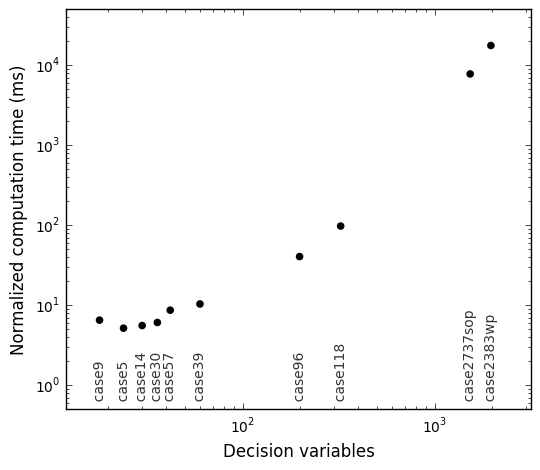

In [99]:
fig = figure(figsize=(6,5))
# scatter(wind_count,bytes_alloc./(lines_processed*1e6),alpha=0.7,edgecolor="")
scatter(wind_count*6,1e3*sec_elapsed./lines_processed,facecolor="black",alpha=1.,s=30,edgecolor="")
yscale("log")
xscale("log")
# axis("equal")
ymin = 0.5
ymax = 10^(4.7)
ylim([ymin;ymax])
xmin = 12
xmax = 10^(3.5)
xlim([xmin;xmax])
# axis([1e3;10^(3.3);10^(-0.5);1e7])
xlabel("Decision variables")
ylabel("Normalized computation time (ms)")
xticks(size=10)
yticks(size=10)
# text(3.5,1.2,"Size indicates no. of lines processed",fontsize=9)

for i in 1:length(lines_processed)
#     text(wind_count[i]*6,1e3*sec_elapsed[i]./lines_processed[i],"    $(cases[i])",
#     color="black",size=10,alpha=0.8,va="bottom",ha="center",rotation=90)
    text(wind_count[i]*6,ymin,"  $(cases[i])",
    color="black",size=10,alpha=0.8,va="bottom",ha="center",rotation=90)
end

savefig("../images/2015-09-17-normalized-performance-square.pdf",bbox_inches="tight")

In [103]:
using JLD
save("../data/2015-09-17-normalized-performance.jld","wind_count",
wind_count,"sec_elapsed",sec_elapsed,"lines_processed",lines_processed,
"score_output",score_output,"bytes_alloc",bytes_alloc,"sec_in_gc",sec_in_gc)

## Better test cases?

It seems like adding a number of wind farms equal to the number of conventional generators works well. Perhaps I should also place the wind farms at generator nodes.

But if I am letting the number of generators determine the number of wind farms, I should sort the cases by number of conventional generators.

### Update: September 17, 2015

I decided to assign wind farms to random nodes. I left overall penetration at 50% and kept the number of wind farms equal to the number of generators.

Randomness makes the figure data impossible to reproduce, so I saved it in case I want to visualize it in a different way.

In [57]:
cnames = casenames()
gen_count = Vector{Int64}()
for case in cnames
    mpc = loadcase(case,describe=false)
    push!(gen_count,length(unique(mpc["gen"][:,1])))
end

In [59]:
cnames[sortperm(gen_count)]

30-element Array{ByteString,1}:
 "case4gs"       
 "case6ww"       
 "case9"         
 "case9Q"        
 "case9target"   
 "case5"         
 "case14"        
 "case30"        
 "case30pwl"     
 "case30Q"       
 "case_ieee30"   
 "case57"        
 "case39"        
 ⋮               
 "case300"       
 "case2737sop"   
 "case1354pegase"
 "case2736sp"    
 "case2383wp"    
 "case3012wp"    
 "case3120sp"    
 "case2746wop"   
 "case2746wp"    
 "case3375wp"    
 "case2869pegase"
 "case9241pegase"

In [150]:
cnames[sortperm(gen_count)[[3;6;7;8;12;13;17;18;19]]]

9-element Array{ByteString,1}:
 "case9"  
 "case5"  
 "case14" 
 "case30" 
 "case57" 
 "case39" 
 "case96" 
 "case118"
 "case300"

In [142]:
sort(gen_count)[[3;6;7;8;12;13;16;17;18;19]]

10-element Array{Int64,1}:
  3
  4
  5
  6
  7
 10
 12
 33
 54
 69

I need to expand the line length vector still more. I will just duplicate the 3.5k-long vector to produce a 7k-long one.

In [37]:
using JLD
ld = load("../data/polish_line_lengths.jld","line_lengths")
save("../data/7k_line_lengths.jld","line_lengths",[ld;ld])

## Old figure

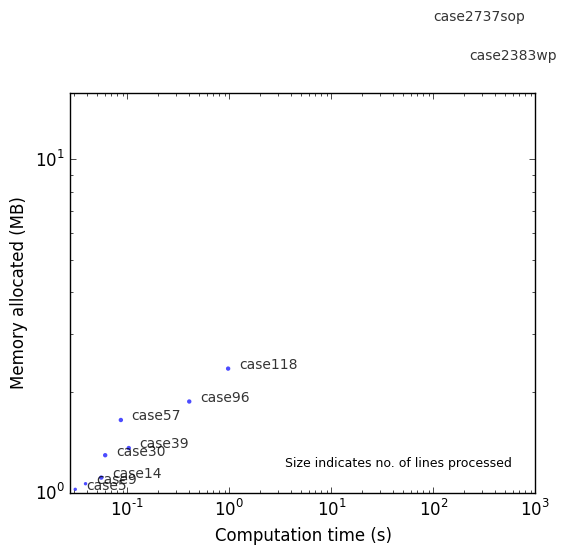

In [101]:
fig = figure(figsize=(6,5))
scatter(sec_elapsed,bytes_alloc./1e6,s=lines_processed,alpha=0.7,edgecolor="")
yscale("log")
xscale("log")
# axis("equal")
ylim([1;10^1.2])
xlim([0;10^3])
xlabel("Computation time (s)")
ylabel("Memory allocated (MB)")
text(3.5,1.2,"Size indicates no. of lines processed",fontsize=9)

for i in 1:length(lines_processed)
    text(sec_elapsed[i]*1.3,bytes_alloc[i]/1e6,cases[i],color="black",size=10,alpha=0.8)#color="#FFB2B2")
end

# savefig("../images/2015-09-15-performance-by-network.svg")